Bring in the RLBench BC data from the saved hdf5 data files for each task. The task files were created with the instructRL/data/collect_data.py script. The task files include an array of data samples.  Each sample is a dict that includes the following keys:

* image - data for 4 camera positions: front_rgb, left_shoulder_rgb, right_shoulder_rgb, wrist_rgb
* instruct - the text instruction
* action - the action vector: [p;q;g] where for RLBench the gripper state is a single scalar open or closed [1,0]

In [1]:
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from getdata import RLBenchDataset
import time
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import pprint as pp
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import Tensor


In [2]:


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        # even indices are sine, odd indices are cosine
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[ batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [3]:

class EncoderAdapter(nn.Module):
    def __init__(self):
        super().__init__()
        # Assuming the input is of shape [batch_size, channels=3, seq_length=396, features=768]
        self.conv2_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2_3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(3, stride=3)
        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(16*14*28, 768)

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        x = F.relu(self.conv2_1(x))  # Reducing the sequence length [batch_size, 16, 396, 768]]
        print(f"Conv2_1 shape: {x.shape}")
        x = self.pool(x) # [batch_size, 16, 132, 256]
        print(f"Pool shape: {x.shape}")
        x = F.relu(self.conv2_2(x)) # [batch_size, 16, 132, 256]
        print(f"Conv2_2 shape: {x.shape}")
        x = self.pool(x) # [batch_size, 16, 44, 85]
        print(f"Pool shape: {x.shape}")
        x = F.relu(self.conv2_3(x)) # [batch_size, 16, 44, 85]
        print(f"Conv2_3 shape: {x.shape}")
        x = self.pool(x) # [batch_size, 16, 14, 28]
        print(f"Pool shape: {x.shape}")
        x = self.flatten(x)  # Flatten the tensor to [batch_size, 16*14*28]
        print(f"Flatten shape: {x.shape}")
        x = self.linear(x)  # Get the final desired shape
        print(f"Linear shape: {x.shape}")
        return x




In [4]:


class ActionDecoderModel(nn.Module):

    def __init__(self, action_dim: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.2, action_seq_len: int = 5,
                 mem_seq_len: int = 5, test_mode=False):
        super().__init__()
        #self.pos_encoder = PositionalEncoding(d_model, dropout=0, max_len=action_seq_len).cuda()
        self.encoder_adapter = EncoderAdapter().cuda()
        #self.encoder_adapter = nn.Linear(action_dim, d_model).cuda()
        decoder_layer = TransformerDecoderLayer(d_model, nhead, d_hid, dropout, batch_first=True).cuda()
        self.transformer_decoder = TransformerDecoder(decoder_layer, nlayers).cuda()
        self.d_model = d_model
        self.linear_action_in = nn.Linear(action_dim, d_model).cuda()
        # The output of the transformer decoder is a sequence of length action_seq_len-1 because it doesn't have sos token
        self.linear_action_out = nn.Linear(d_model, action_dim).cuda()
        self.test_mode = test_mode
        

    def forward(self, actions: Tensor, memory: Tensor) -> Tensor:
        """
        actions: [batch_size, action_seq_len, action_dim]
        memory: [batch_size, n_images, mem_seq_len, d_model]
        """
        actions = self.linear_action_in(actions)
        # actions = self.pos_encoder(actions)
        memory = memory.mean(dim=-2)
        memory = memory.reshape(memory.size(0), -1, memory.size(-1))
        memory = memory[:,0:3,:] # Only do this for ReachTarget otherwise need to implement smart train memory mask
        if self.test_mode:
            # If mixing tasks, then we will need padding masks in the batch
            output = self.transformer_decoder(
                tgt=actions, 
                memory=memory
                )
            
        else:
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(actions.size(1)).cuda()
            # causal memory mask to prevent attending to future actions of size mem_seq_len x action_seq_len upper triangular part should be True (is masked)
            mem_mask = torch.triu(torch.ones(actions.size(1), memory.size(1)), diagonal=1).bool().cuda()
            
            # If mixing tasks, then we will need padding masks in the batch
            output = self.transformer_decoder(
                tgt=actions, 
                memory=memory, 
                tgt_mask=tgt_mask,
                )


        output = self.linear_action_out(output)
        return output

In [5]:
# The encoder embeddings from the Flava encoder will have dimensions [batch size, seq length, num cameras, num tokens, embedding dim]
x = torch.rand(5, 2, 3, 396, 768)
# Apply 1D ave pooling to the second to last dimension
x = x.mean(dim=-2)
x = x.reshape(x.size(0), -1, x.size(-1))
print(f"Input shape: {x.shape}")

Input shape: torch.Size([5, 6, 768])


In [6]:

### DON'T FORGET to change the number of workers in the dataloader to 0 if debugging, debugger doesn't like mulitiple threads  ###

# Read in the RLBench training data.  The RLBenchDataset class is a subclass of the PyTorch Dataset class.
batch_size = 10
task_name = "reach_target"
# Load the training dataset and create a PyTorch DataLoader object.
train_dataset = RLBenchDataset(
    update=None,
    dataset_name=task_name,
    start_offset_ratio=None,
    split="train",
)

train_loader = torch.utils.data.DataLoader(    
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0)

# Load the validation dataset and create a PyTorch DataLoader object.
val_dataset = RLBenchDataset(
    update=None,
    dataset_name=task_name,
    start_offset_ratio=None,
    split="val",
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0)

In [7]:
print(f"Training dataset batch info:")
for i, (data, target) in enumerate(train_loader):
    print("action:", data['action'].shape)
    print("encoder_emb:", data['encoder_emb'].shape)
    print("target:", target.shape)
    break
print("num batches: " + str(len(train_loader)))

print(f"Val dataset batch info:")
for i, (data, target) in enumerate(val_loader):
    print("action:", data['action'].shape)
    print("encoder_emb:", data['encoder_emb'].shape)
    print("target:", target.shape)
    break
print("num batches: " + str(len(val_loader)))


Training dataset batch info:
action: torch.Size([10, 1, 8])
encoder_emb: torch.Size([10, 1, 3, 395, 768])
target: torch.Size([10, 1, 8])
num batches: 60
Val dataset batch info:
action: torch.Size([10, 1, 8])
encoder_emb: torch.Size([10, 1, 3, 395, 768])
target: torch.Size([10, 1, 8])
num batches: 3


In [8]:

# max number of tokens in encoder embeddings for the training tasks in a batch. Can be constant if all same task, otherwise needs to be computed. Also determines whether a padding mask must be applied.  Determines the size of the causal mask and max
# max sequence length of the decoder action sequence and target output sequence. Decoder input size is seq_len + 2 to account for the start of sequence (sos) and end of sequence (eos) tokens.
action_seq_len = data['action'].shape[1]  # sos + action + eos, will need batch padding when mixing tasks
mem_seq_len = data['encoder_emb'].shape[1] 

action_dim = 8 # feature length of the action vector [p;q;g]
mm_dim = 768  # embedding dimension of the encoder (768,)
d_hid = 768  # dimension of the feedforward network model in ``nn.TransformerDecoder``
nlayers = 1  # number of nn.TransformerDecoderLayer in nn.TransformerDecoder
nhead = 1  # number of attention heads in nn.MultiheadAttention
dropout = 0.1  # dropout probability
model = ActionDecoderModel(
    action_dim=action_dim, 
    d_model = mm_dim, 
    nhead = nhead, 
    d_hid = d_hid, 
    nlayers = nlayers, 
    dropout = dropout, 
    action_seq_len = action_seq_len,
    mem_seq_len = mem_seq_len,
    ).cuda()

In [9]:
# print whether model is on GPU or CPU
print(f"Model is on {next(model.parameters()).device}")

# Display the model architecture and number of trainable parameters
#print(model)

Model is on cuda:0


In [10]:


loss_fn = nn.MSELoss(
    reduction='mean',    
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, 
    gamma=0.99,
    verbose=False
)


In [11]:

def evaluate(model: nn.Module, val_loader: iter) -> float:
    
    model.eval()  # turn on evaluation mode    
    with torch.no_grad():
        for i, (batch, targets) in enumerate(val_loader):
            encoder_embeddings = batch['encoder_emb'].cuda()
            action_inputs = batch['action'].cuda()
            targets = torch.squeeze(targets).cuda()
            outputs = model(actions=action_inputs, memory=encoder_embeddings)
            # print the output and target values side by side to compare
            #print(f"val: outputs: {outputs}: targets: {targets}")
            batch_val_loss = loss_fn(outputs, targets)
            val_loss_buf[epoch, i] = batch_val_loss.item()
            

In [12]:
torch.set_printoptions(precision=4, sci_mode=False, linewidth=150)
epochs = 10 # The number of epochs

# Create a 2D array of zeros to store the training loss for each epoch x batch.
train_loss_buf = np.zeros((epochs, len(train_loader)))
val_loss_buf = np.zeros((epochs, len(val_loader)))

for epoch in range(epochs):
    epoch_start_time = time.time()

    log_interval_loss = 0.
    start_time = time.time()

    for i, (batch, targets) in enumerate(train_loader):

        encoder_embeddings = batch['encoder_emb'].cuda()
        action_inputs = batch['action'].cuda()
        optimizer.zero_grad()
        outputs = model(actions=action_inputs, memory=encoder_embeddings)        
        targets = targets.cuda()
        # print the elements of outputs and targets side by side to compare the values
        # print(f"train: outputs: {outputs}| targets: {targets}")



        # Compare target sequence to output sequence, ignoring the output token after the eos token
        batch_train_loss = loss_fn(outputs, targets)
        batch_train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        log_interval_loss += batch_train_loss.item()
        train_loss_buf[epoch, i] = batch_train_loss.item()
        log_interval = 10
        if i % log_interval == 0 and i > 0:
                cur_loss = log_interval_loss / log_interval
                elapsed = time.time() - start_time
                # print(f'| epoch: {epoch:3d} | {i+1:5d}/{len(train_loader):5d} batches | '
                #       f'lr: {scheduler.get_last_lr()[0]:02.3f} | ms/batch: {elapsed * 1000 / log_interval:5.2f} | '
                #       f'log batch loss: {log_interval_loss:1.5f} | ')
                log_interval_loss = 0
                start_time = time.time()



    evaluate(model, val_loader)
    scheduler.step()
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'end of epoch: {epoch:3d} | epoc time: {elapsed:5.2f}s ')
    # print the total training and validation loss for the epoch
    print(f'train loss: {train_loss_buf[epoch,:].mean():6.7f}')              
    print(f'valid loss: {val_loss_buf[epoch,:].mean():6.7f}')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:02.6f}')
    print('-' * 89)

/home/levi/code/flava-action-xformer/.venv/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
/home/levi/code/flava-action-xformer/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10, 8])) that is different to the input size (torch.Size([10, 1, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-----------------------------------------------------------------------------------------
end of epoch:   0 | epoc time:  4.06s 
train loss: 0.4171932
valid loss: 0.1164725
Learning Rate: 0.000990
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
end of epoch:   1 | epoc time:  3.27s 
train loss: 0.0652211
valid loss: 0.0494906
Learning Rate: 0.000980
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
end of epoch:   2 | epoc time:  3.29s 
train loss: 0.0506489
valid loss: 0.0460039
Learning Rate: 0.000970
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
end of epoch:   3 | epoc time:  3.50s 
train loss

In [13]:
SAVE_MODEL = False

# Model path with date suffix
datestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
MODEL_PATH = f"/home/levi/data/action_decoder_model_{datestr}.pt"
if SAVE_MODEL:
    torch.save(model, MODEL_PATH)

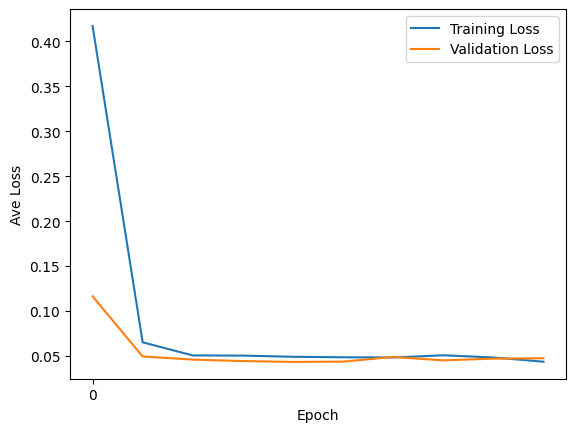

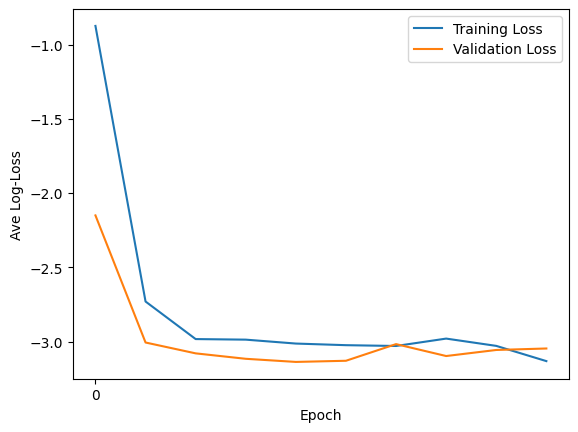

In [14]:
# plot the training loss for each epoch

plt.plot(np.vstack((np.mean(train_loss_buf, axis=1), np.mean(val_loss_buf, axis=1))).T)
# set the x axis tick labels to be the epoch numbers
plt.xlabel('Epoch')
plt.ylabel('Ave Loss')
plt.xticks(np.arange(0, epochs, step=25))

# add a legend
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


plt.clf()
plt.plot(np.log(np.vstack((np.mean(train_loss_buf, axis=1), np.mean(val_loss_buf, axis=1))).T))
plt.xlabel('Epoch')
plt.ylabel('Ave Log-Loss')
plt.xticks(np.arange(0, epochs, step=25))


# add a legend
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [15]:
task_name = "reach_target"
# Load the training dataset and create a PyTorch DataLoader object.
viz_dataset = RLBenchDataset(
    update=None,
    dataset_name=task_name,
    start_offset_ratio=None,
    split="train",
)
viz_loader = torch.utils.data.DataLoader(    
    dataset=train_dataset, 
    batch_size=1, 
    shuffle=True, 
    num_workers=0)

inputs: tensor([[[     0.2785,     -0.0082,      1.4719,     -0.0000,      0.9927,     -0.0000,      0.1209,      1.0000]]], device='cuda:0')
outputs: tensor([[[ 0.3010, -0.1700,  0.9065,  0.0575, -1.0013, -0.0890,  0.0059,  0.9831]]], device='cuda:0')
targets: tensor([     0.0360,     -0.1651,      1.1000,      0.0000,     -1.0000,     -0.0003,      0.0001,      1.0000], device='cuda:0')


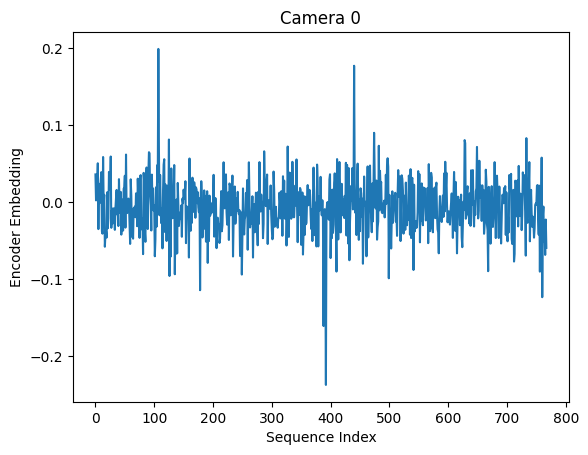

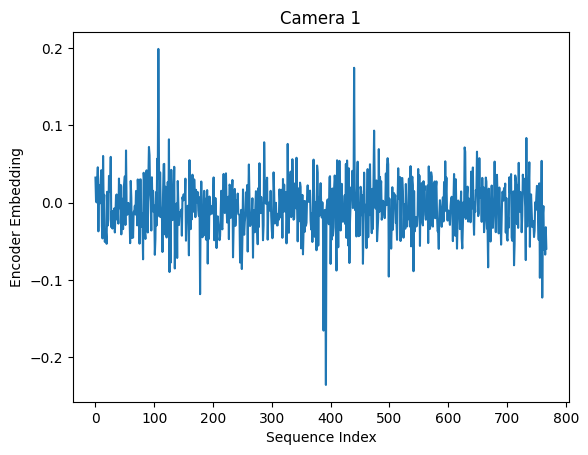

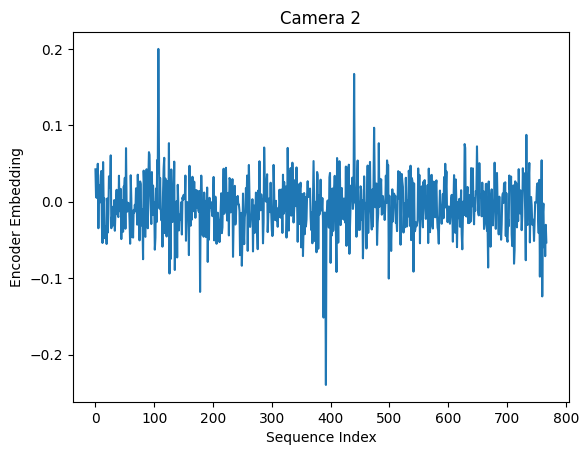

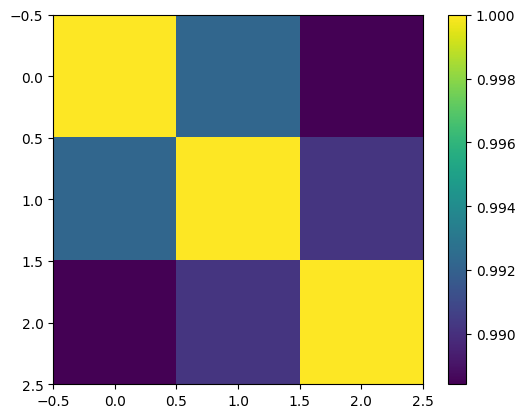

In [16]:
# display the output of specific training data results compared to targets
model.eval()  # turn on evaluation mode    
with torch.no_grad():
    (batch, targets) = next(iter(viz_loader))
    encoder_embeddings = batch['encoder_emb'].cuda()
    action_inputs = batch['action'].cuda()
    targets = torch.squeeze(targets).cuda()
    outputs = model(actions=action_inputs, memory=encoder_embeddings)
    # # print the output and target values side by side to compare
    print(f"inputs: {action_inputs}")
    print(f"outputs: {outputs}")
    print(f"targets: {targets}")
# batch_val_loss = loss_fn(outputs, targets)
    
# Compute the mean of the encoder embeddings for each camera view
encoder_embeddings = encoder_embeddings.mean(dim=-2)
# Normalize the mean embeddings
encoder_embeddings = F.normalize(encoder_embeddings, p=2, dim=-1)
# Squeeze out the batch dimension
encoder_embeddings = encoder_embeddings.squeeze()
# plot each camera vector as a line on separate plots side by side
for i in range(encoder_embeddings.shape[0]):
    plt.plot(encoder_embeddings[i,:].cpu().numpy())
    plt.xlabel('Sequence Index')
    plt.ylabel('Encoder Embedding')
    plt.title(f"Camera {i}")
    plt.show()
# plot the kernel matrix of the inner product between the encoder embeddings for each camera view as a heatmap with a colorbar
plt.imshow(torch.mm(encoder_embeddings, encoder_embeddings.T).cpu().numpy())
plt.colorbar()
plt.show()



In [17]:
# Now lets connect the current model to RLBench to step through the task and evaluate how often it receives a reward in the task.
from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import EndEffectorPoseViaPlanning
from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.observation_config import ObservationConfig
from rlbench.tasks import FS10_V1, ReachTarget, PickUpCup

In [18]:
from transformers import FlavaProcessor, FlavaModel
import numpy as np
import torch

class SlowAgent(object):
    """
    Agent that uses task description and observation to infer FLAVA autoencoder embeddings and then 
    predict the next action with the provided decoder autoregressively.
    
    """

    def __init__(self, decoder_model, start_action):
        self.action_shape = (8,)        
        self.encoder_emb = np.empty((1,0,3,395,768),dtype=np.float32)
        
        # add two dimensions on the front of the action vector
        start_action = torch.tensor(np.expand_dims(start_action, axis=(0,1)), dtype=torch.float32)
        self.decoder_actions = start_action.cuda()
        # Retrieve the Flava model and processor
        self.flava_model = FlavaModel.from_pretrained('facebook/flava-full')
        self.flava_processor = FlavaProcessor.from_pretrained('facebook/flava-full')
        self.action_decoder_model = decoder_model


    def get_flava_embeddings(self, images, instruction):
        # Convert the observation and instruction into a batch of inputs for the Flava model
        instruction = [instruction for n in range(len(images))] # repeat the instruction for each image
        inputs = self.flava_processor(images, instruction, return_tensors="pt", padding="max_length", max_length=197, return_codebook_pixels=False, return_image_mask=False)
        # Pass the inputs through the Flava model
        outputs = self.flava_model(**inputs)
        # Retrieve the multimodal embeddings from the Flava model outputs
        multimodal_embeddings = outputs.multimodal_embeddings.detach().numpy()
        return multimodal_embeddings
    
    def act(self, images, instruction):        
        # Here we are submitting on image and one instruction at a time in an autoregressive fashion
        encoder_emb = self.get_flava_embeddings(images, instruction)
        #add axes to encoder_emb to match the expected shape of the self.encoder_emb
        encoder_emb = np.expand_dims(encoder_emb, axis=(0,1))
        # Concatenate the embedding to the encoder embeddings
        self.encoder_emb = np.concatenate((self.encoder_emb, encoder_emb), axis=1)

        self.action_decoder_model.eval()  # turn on evaluation mode    
        memory_emb = torch.from_numpy(self.encoder_emb).cuda()
        with torch.no_grad():
            # Get the decoder action from the action decoder model
            decoder_action = self.action_decoder_model(actions=self.decoder_actions, memory=memory_emb) 
            # Normalize the quaternion values
            decoder_action[0,0,3:7] = decoder_action[0,0,3:7] / torch.norm(decoder_action[0,0,3:7])           
            # Add the action to the decoder actions
            self.decoder_actions = torch.cat((self.decoder_actions, decoder_action), dim=1)
        return decoder_action.detach().cpu().numpy().squeeze()


/home/levi/code/flava-action-xformer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
obs_config = ObservationConfig()
obs_config.set_all(True)

env = Environment(
    action_mode=MoveArmThenGripper(
        arm_action_mode=EndEffectorPoseViaPlanning(absolute_mode=True), gripper_action_mode=Discrete()),
    obs_config=ObservationConfig(),
    headless=False)
env.launch()

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.
Some weights of the model checkpoint at facebook/flava-full were not used when initializing FlavaModel: ['mmm_image_head.transform.dense.weight', 'image_codebook.blocks.group_2.group.block_1.res_path.path.conv_3.bias', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_2.weight', 'mim_head.transform.dense.bias', 'image_codebook.blocks.group_3.group.block_2.res_path.path.conv_3.bias', 'image_codebook.blocks.input.weight', 'image_codebook.blocks.group_3.group.block_2.res_path.path.conv_1.bias', 'mmm_text_head.decoder.bias'

touch the red ball with the panda gripper


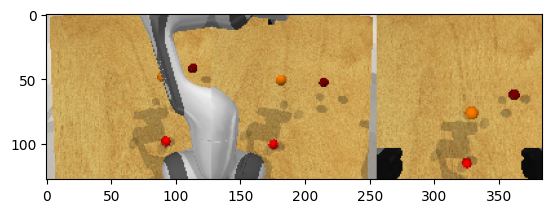

In [20]:
from data.utils import _get_cont_action

# Get the task
task = env.get_task(ReachTarget)
# Reset the task
descriptions, obs = task.reset()

# Instantiate the agent
start_action = torch.tensor(_get_cont_action(obs))
model.test_mode = False
agent = SlowAgent(decoder_model=model, start_action=start_action)

instruction = descriptions[1]
print(instruction)
# show the three camera views in one plot
# Concatenate the three camera views into one image
image = np.concatenate((obs.left_shoulder_rgb, obs.right_shoulder_rgb, obs.wrist_rgb), axis=1)
plt.imshow(image)
plt.show()



In [21]:
images = [obs.left_shoulder_rgb, obs.right_shoulder_rgb, obs.wrist_rgb]
flava_model = FlavaModel.from_pretrained('facebook/flava-full')
flava_processor = FlavaProcessor.from_pretrained('facebook/flava-full')
instruction = descriptions[1]
inst = [instruction for n in range(len(images))] # repeat the instruction for each image

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.
Some weights of the model checkpoint at facebook/flava-full were not used when initializing FlavaModel: ['mmm_image_head.transform.dense.weight', 'image_codebook.blocks.group_2.group.block_1.res_path.path.conv_3.bias', 'image_codebook.blocks.group_4.group.block_1.res_path.path.conv_2.weight', 'mim_head.transform.dense.bias', 'image_codebook.blocks.group_3.group.block_2.res_path.path.conv_3.bias', 'image_codebook.blocks.input.weight', 'image_codebook.blocks.group_3.group.block_2.res_path.path.conv_1.bias', 'mmm_text_head.decoder.bias'

In [22]:
inputs = flava_processor(images, inst, return_tensors="pt", padding="max_length", max_length=50, return_codebook_pixels=False, return_image_mask=False)
# Pass the inputs through the Flava model
outputs = flava_model(**inputs)
# Retrieve the multimodal embeddings from the Flava model outputs
mm_embeddings = outputs.multimodal_embeddings.detach().numpy()
print(mm_embeddings.shape)

/home/levi/code/flava-action-xformer/.venv/lib/python3.11/site-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


(3, 248, 768)


In [33]:
mm_embeddings = outputs.multimodal_output.last_hidden_state.detach().numpy()

In [ ]:
# Take the inner product of the first two embeddings
print(np.trace(np.dot(mm_embeddings[0,...], mm_embeddings[1,...].T)))

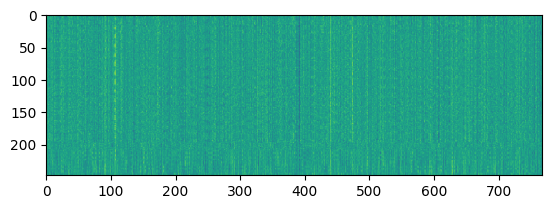

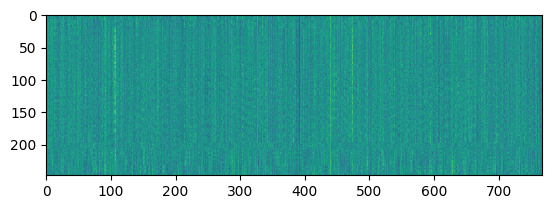

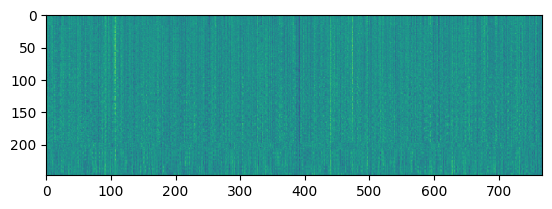

In [34]:
# Display each of the three 2D embeddings
for i in range(mm_embeddings.shape[0]):
    plt.imshow(mm_embeddings[i,:,:])
    plt.show()
# Compute the difference between the first two embeddings
# emb_diff = mm_embeddings[0,:,:] - mm_embeddings[1,:,:]
# # Plot the histogram of the embedding differences
# plt.hist(emb_diff.flatten())

In [ ]:
# Take steps in the task and print the reward
for i in range(1):
    action = agent.act([obs.left_shoulder_rgb, obs.right_shoulder_rgb, obs.wrist_rgb], instruction)
    print(f'action: {action}')
    if action[0] > 0:
        obs, reward, terminate = task.step(action)
        print(f'Step: {i} Reward: {reward}')
    else:
        print("No action taken")
        break
    image = np.concatenate((obs.left_shoulder_rgb, obs.right_shoulder_rgb, obs.wrist_rgb), axis=1)
    plt.imshow(image)

In [ ]:
env.shutdown()